In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gc
import numpy as np
import datetime
import re
import swifter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as pl

In [4]:
DATA = "Dataset/"

In [15]:
%%time
metadata_sample = pd.read_parquet(DATA + "df_metadata_sample_clean.parquet.gzip",engine='pyarrow')

Wall time: 28.2 s


In [16]:
metadata_sample

,index,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,subs_before_video,tags_count,num_comms,description,title
0,676973,Gaming,UCrnftLporTV1YgYbVi7GFsw,31,TqLn2hX6zoA,655,314,2019-03-13,45868.0,30595.541667,15,39.0,Send me your submissions to be featured https:...,Twitch Stream Fails and Epic Moments Compilati...
1,66343748,Sports,UC2EuJ9xTs0XkDZI9YGx7QZA,51,MCEQL6g5EIU,614,468,2017-03-25,29088.0,20086.343750,15,179.0,If Floyd Mayweather vs. Conor McGregor ends up...,Conor McGregor's Best Asset: Undermining Doubt...
2,12315685,Entertainment,UCiJfiEg1FImWsVuEu0L8X6Q,1,l3_IlJr-8_U,30,44,2016-08-18,11506.0,126756.750000,8,0.0,Watch Srirastu Subhamastu telugu movie dailogu...,Srirastu Subhamastu Latest Teaser | Allu Siris...
3,29036231,People & Blogs,UCVptfwYcLxRED8w4Efy0CsA,88,y126khD2Q5k,373,1788,2016-04-05,189885.0,2942.500000,41,125.0,COACHING & TRAINING PLANS\nVisit harryruns.com...,Interval Training: How To Become a Faster Runner
4,56543085,Film & Animation,UCAP57cF-FSjJKzzXg7ntPlQ,0,JCuwthnCRpg,120,380,2019-01-08,7559.0,130292.885417,1,23.0,Now in theatres!,STALKER - Janus Films Trailer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257064,39977981,Gaming,UCN-Klifn9C7kINwpIA0uOHw,2,QhWTZppzqxI,1579,302,2019-02-11,7518.0,305116.869792,13,49.0,🎤 Check out these links! 🎤\nhttp://patreon.com...,[7] Ace Combat 7: Skies Unknown w/ GaLm
1257065,71798200,Gaming,UCskB-HpWs7BAVPvjdJf9-6g,1,1DytQ27ZFCQ,743,15,2015-12-29,116.0,6585.125000,8,19.0,Hey friends it's me KaOs Broly I hope you enjo...,Splatoon - New Piranha Pit Map Gameplay
1257066,35917598,Music,UCQEloCMWEZFep85nHfbbg8Q,0,wiP1xD1Tapc,389,0,2014-01-24,175.0,95064.375000,2,0.0,For more videos click | http://goo.gl/6NU4DG\n...,Haryanvi Krishan Bhajan Sri Radhe Govinda Jug ...
1257067,54370862,People & Blogs,UCBu0KdNokE4MqdkacvH37_A,1,3qmjq0j3-zE,143,1,2019-01-18,55.0,25481.217593,1,0.0,A new ice cream shop in North Texas is turning...,New ice cream shop turning dessert into a fine...


In [31]:
metadata_sample['virality']=metadata_sample['view_count'].apply(lambda x :np.log(x+1))/metadata_sample['subs_before_video'].apply(lambda x:np.log(x+1))

In [43]:
print('The top 95% of videos in terms of virality have a virality index of {:.4f}'.format(np.quantile(metadata_sample['virality'],0.95)))

The top 95% of videos in terms of virality have a virality index of 1.2095


In [41]:
metadata_viral=metadata_sample[metadata_sample['virality']>=np.quantile(metadata_sample['virality'],0.95)]

# WORDCLOUD

In [19]:
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
token = WordPunctTokenizer()

In [20]:
re_list = ['(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?', '@[A-Za-z0-9_]+','#']
combined_re = re.compile( '|'.join( re_list) )

In [21]:
regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)

In [23]:
def cleaning_text(t):
    del_amp = BeautifulSoup(t, 'lxml')
    del_amp_text = del_amp.get_text()
    del_link_mentions = re.sub(combined_re, '', del_amp_text)
    del_emoticons = re.sub(regex_pattern, '', del_link_mentions)
    lower_case = del_emoticons.lower()
    words = token.tokenize(lower_case)
    result_words = [x for x in words if len(x) > 2]
    return (" ".join(result_words)).strip()

# Viral only

In [49]:
%%time
cleaned_text_series=metadata_viral['title'].swifter.apply(lambda x:cleaning_text(x))

Pandas Apply:   0%|          | 0/62854 [00:00<?, ?it/s]

C:\Users\Corentin\anaconda3\envs\python3.7\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Wall time: 52.2 s


In [53]:
cleaned_text_viral=list(cleaned_text_series.values)
print(cleaned_text_viral)
string = pd.Series(cleaned_text_viral).str.cat(sep=' ')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



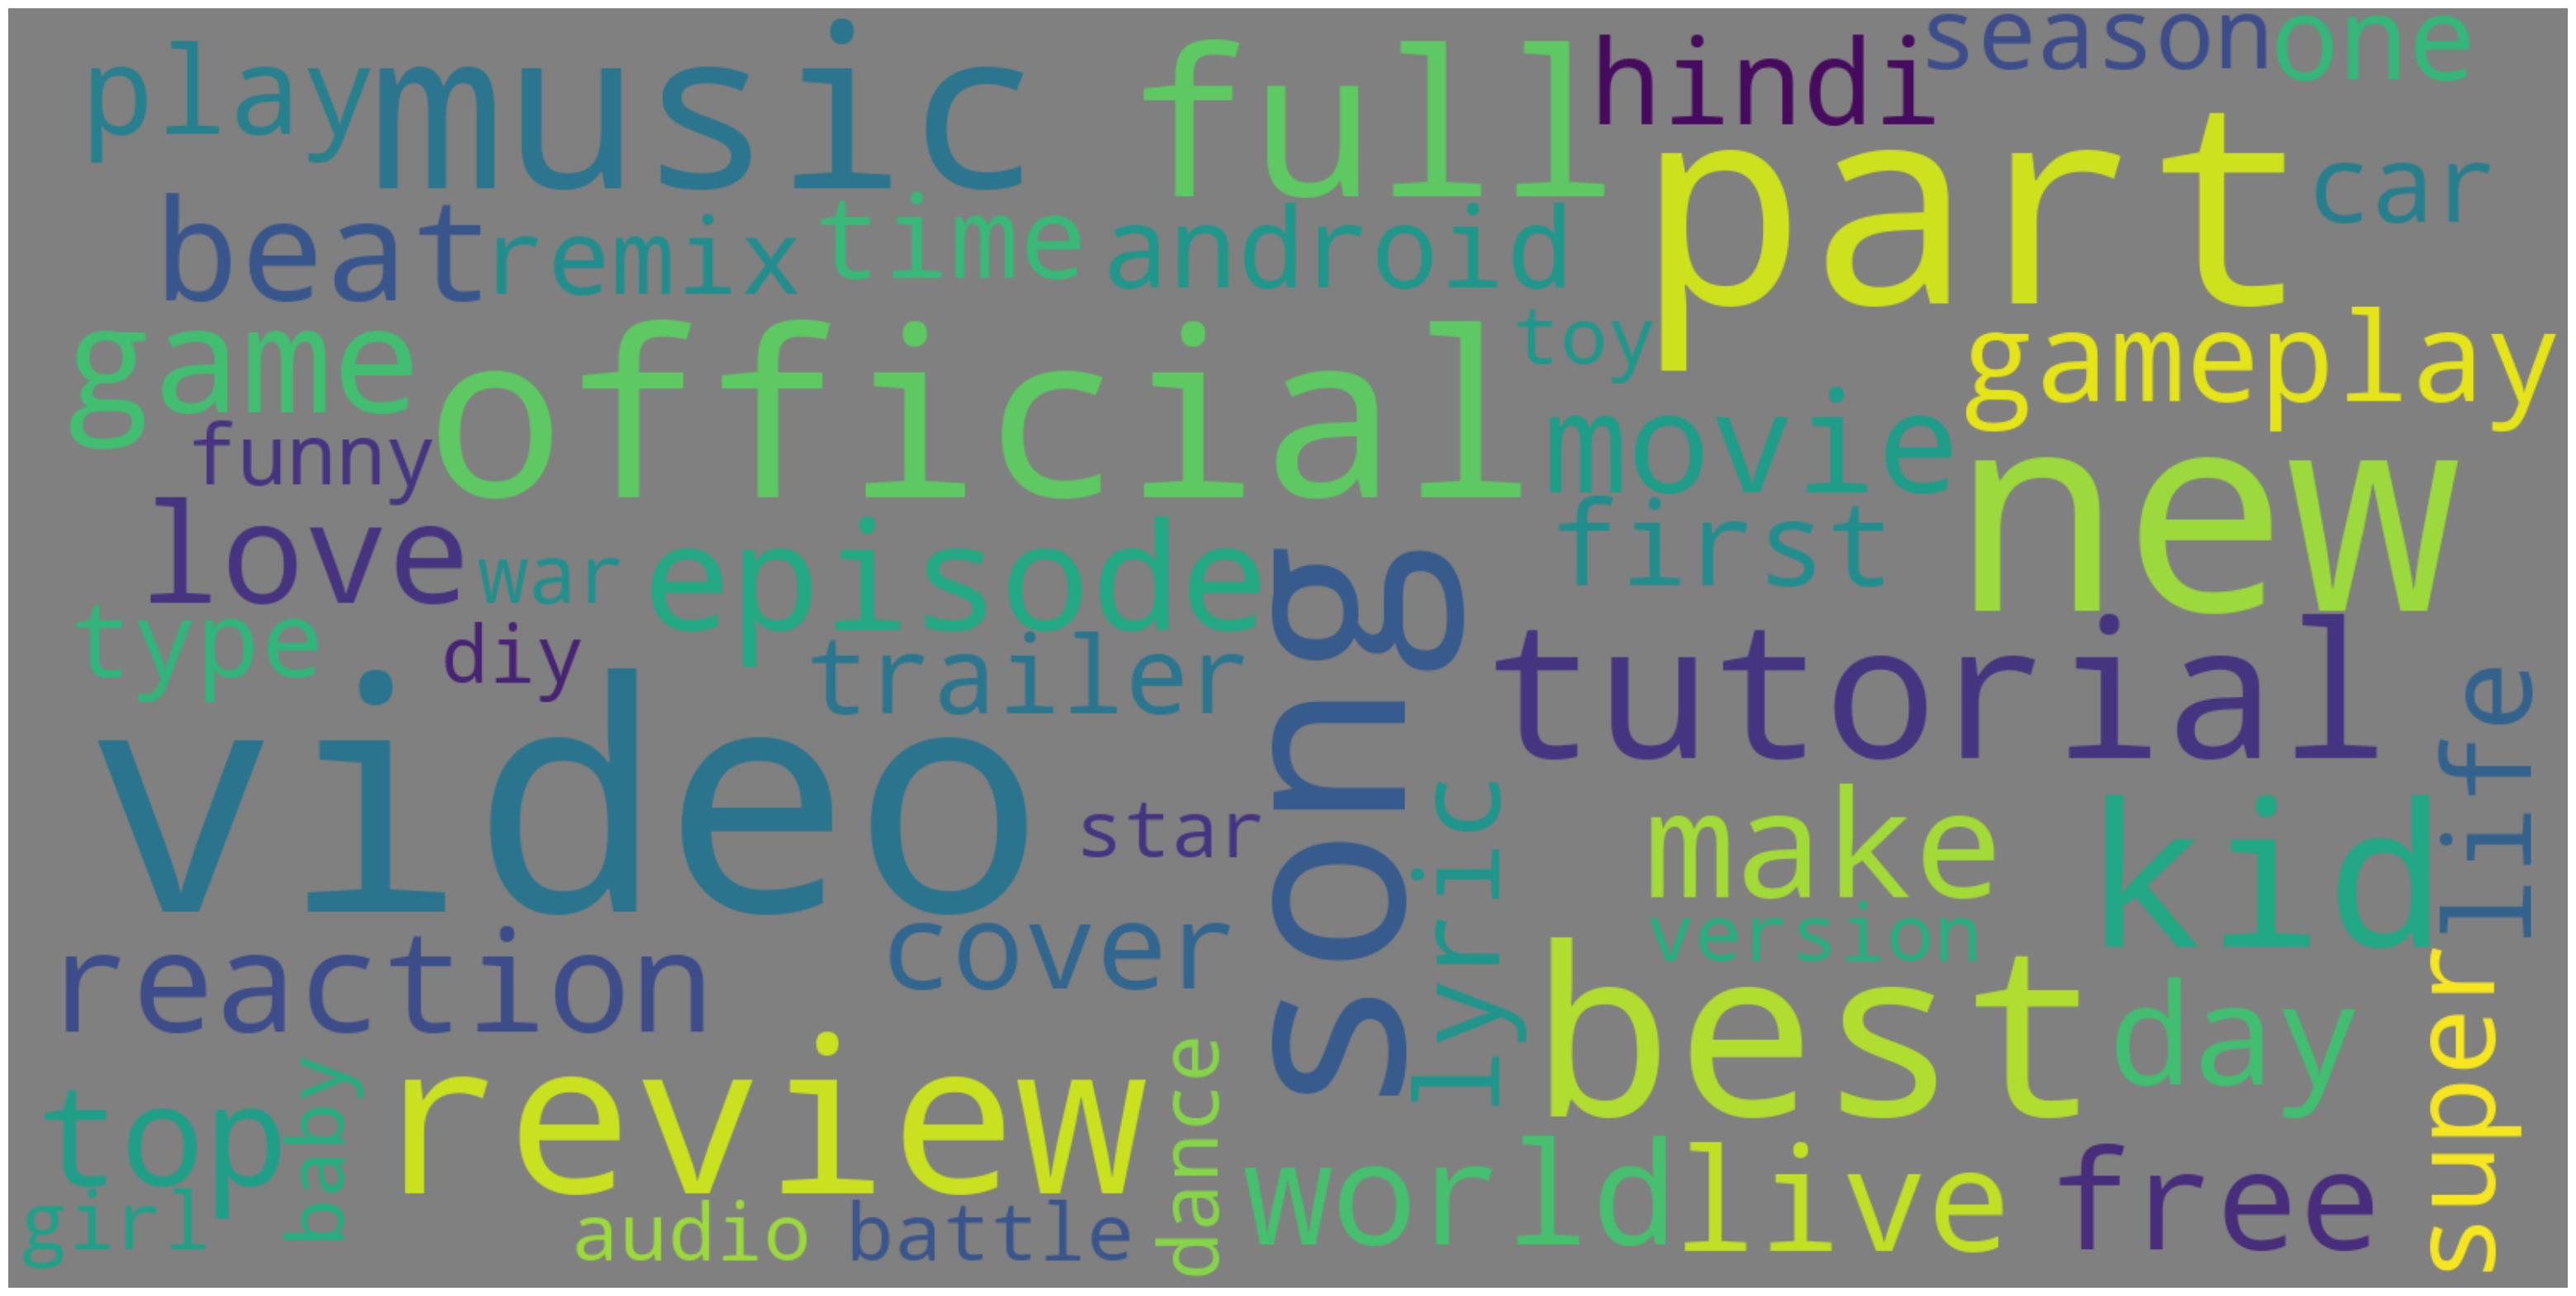

Wall time: 9.47 s


In [54]:
%%time
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=200,max_words=50,collocations=False, background_color='grey').generate(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [55]:
wordcloud.to_file('title_wordcloud_viral.png')

# Whole Sample

In [24]:

print("Cleaning the titles...\n")
cleaned_titles = []
for i in range(0,len(metadata_sample)):
    if( (i+1)%10000 == 0 ):
        print("Titles {} of {} have been processed".format(i+1,len(metadata_sample)))                                                                  
    cleaned_titles.append(cleaning_text((metadata_sample.title[i])))

Cleaning the tweets...



C:\Users\Corentin\anaconda3\envs\python3.7\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\Users\Corentin\anaconda3\envs\python3.7\lib\site-packages\bs4\__init__.py:408: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


Tweets 10000 of 1257069 have been processed
Tweets 20000 of 1257069 have been processed
Tweets 30000 of 1257069 have been processed
Tweets 40000 of 1257069 have been processed
Tweets 50000 of 1257069 have been processed
Tweets 60000 of 1257069 have been processed
Tweets 70000 of 1257069 have been processed
Tweets 80000 of 1257069 have been processed
Tweets 90000 of 1257069 have been processed
Tweets 100000 of 1257069 have been processed
Tweets 110000 of 1257069 have been processed
Tweets 120000 of 1257069 have been processed
Tweets 130000 of 1257069 have been processed
Tweets 140000 of 1257069 have been processed
Tweets 150000 of 1257069 have been processed
Tweets 160000 of 1257069 have been processed
Tweets 170000 of 1257069 have been processed
Tweets 180000 of 1257069 have been processed
Tweets 190000 of 1257069 have been processed
Tweets 200000 of 1257069 have been processed
Tweets 210000 of 1257069 have been processed
Tweets 220000 of 1257069 have been processed
Tweets 230000 of 12

In [25]:
cleaned_titles

['twitch stream fails and epic moments compilation',
 'conor mcgregor best asset undermining doubt about his limits',
 'srirastu subhamastu latest teaser allu sirish lavanya tripathi parasuram shreyas media',
 'interval training how become faster runner',
 'stalker janus films trailer',
 'chan millanes tuldok teaser',
 'putin says helsinki summit with trump was success',
 'forensic files season episode northern exposure',
 'lies about god god doesn care',
 'hollyoaks nico blake final episode 21st june 2018 part',
 'pediatric heart failure heart transplantation mottchat',
 'danniella vian case update',
 'bups saggu lehmber hussainpuri matha tekhiya redefined',
 'sexy photo shoot',
 'dopa kog maw jhin adc patch ranked',
 'tiny haul sephora new yorker and',
 'mercedes benz class 2016 renault scenic 2016',
 'abspacken mit squip',
 'mini skateboard tricks with jonny giger',
 'rally',
 'new fortnite update shopping carts fortnite',
 'raw aerial video scene auburn trash transfer station after

In [26]:
string = pd.Series(cleaned_titles).str.cat(sep=' ')

In [28]:

stopwords = set(STOPWORDS)
#stopwords.update(["biden","joe biden","donald","donald trump","trump","joe","don","doesn"])

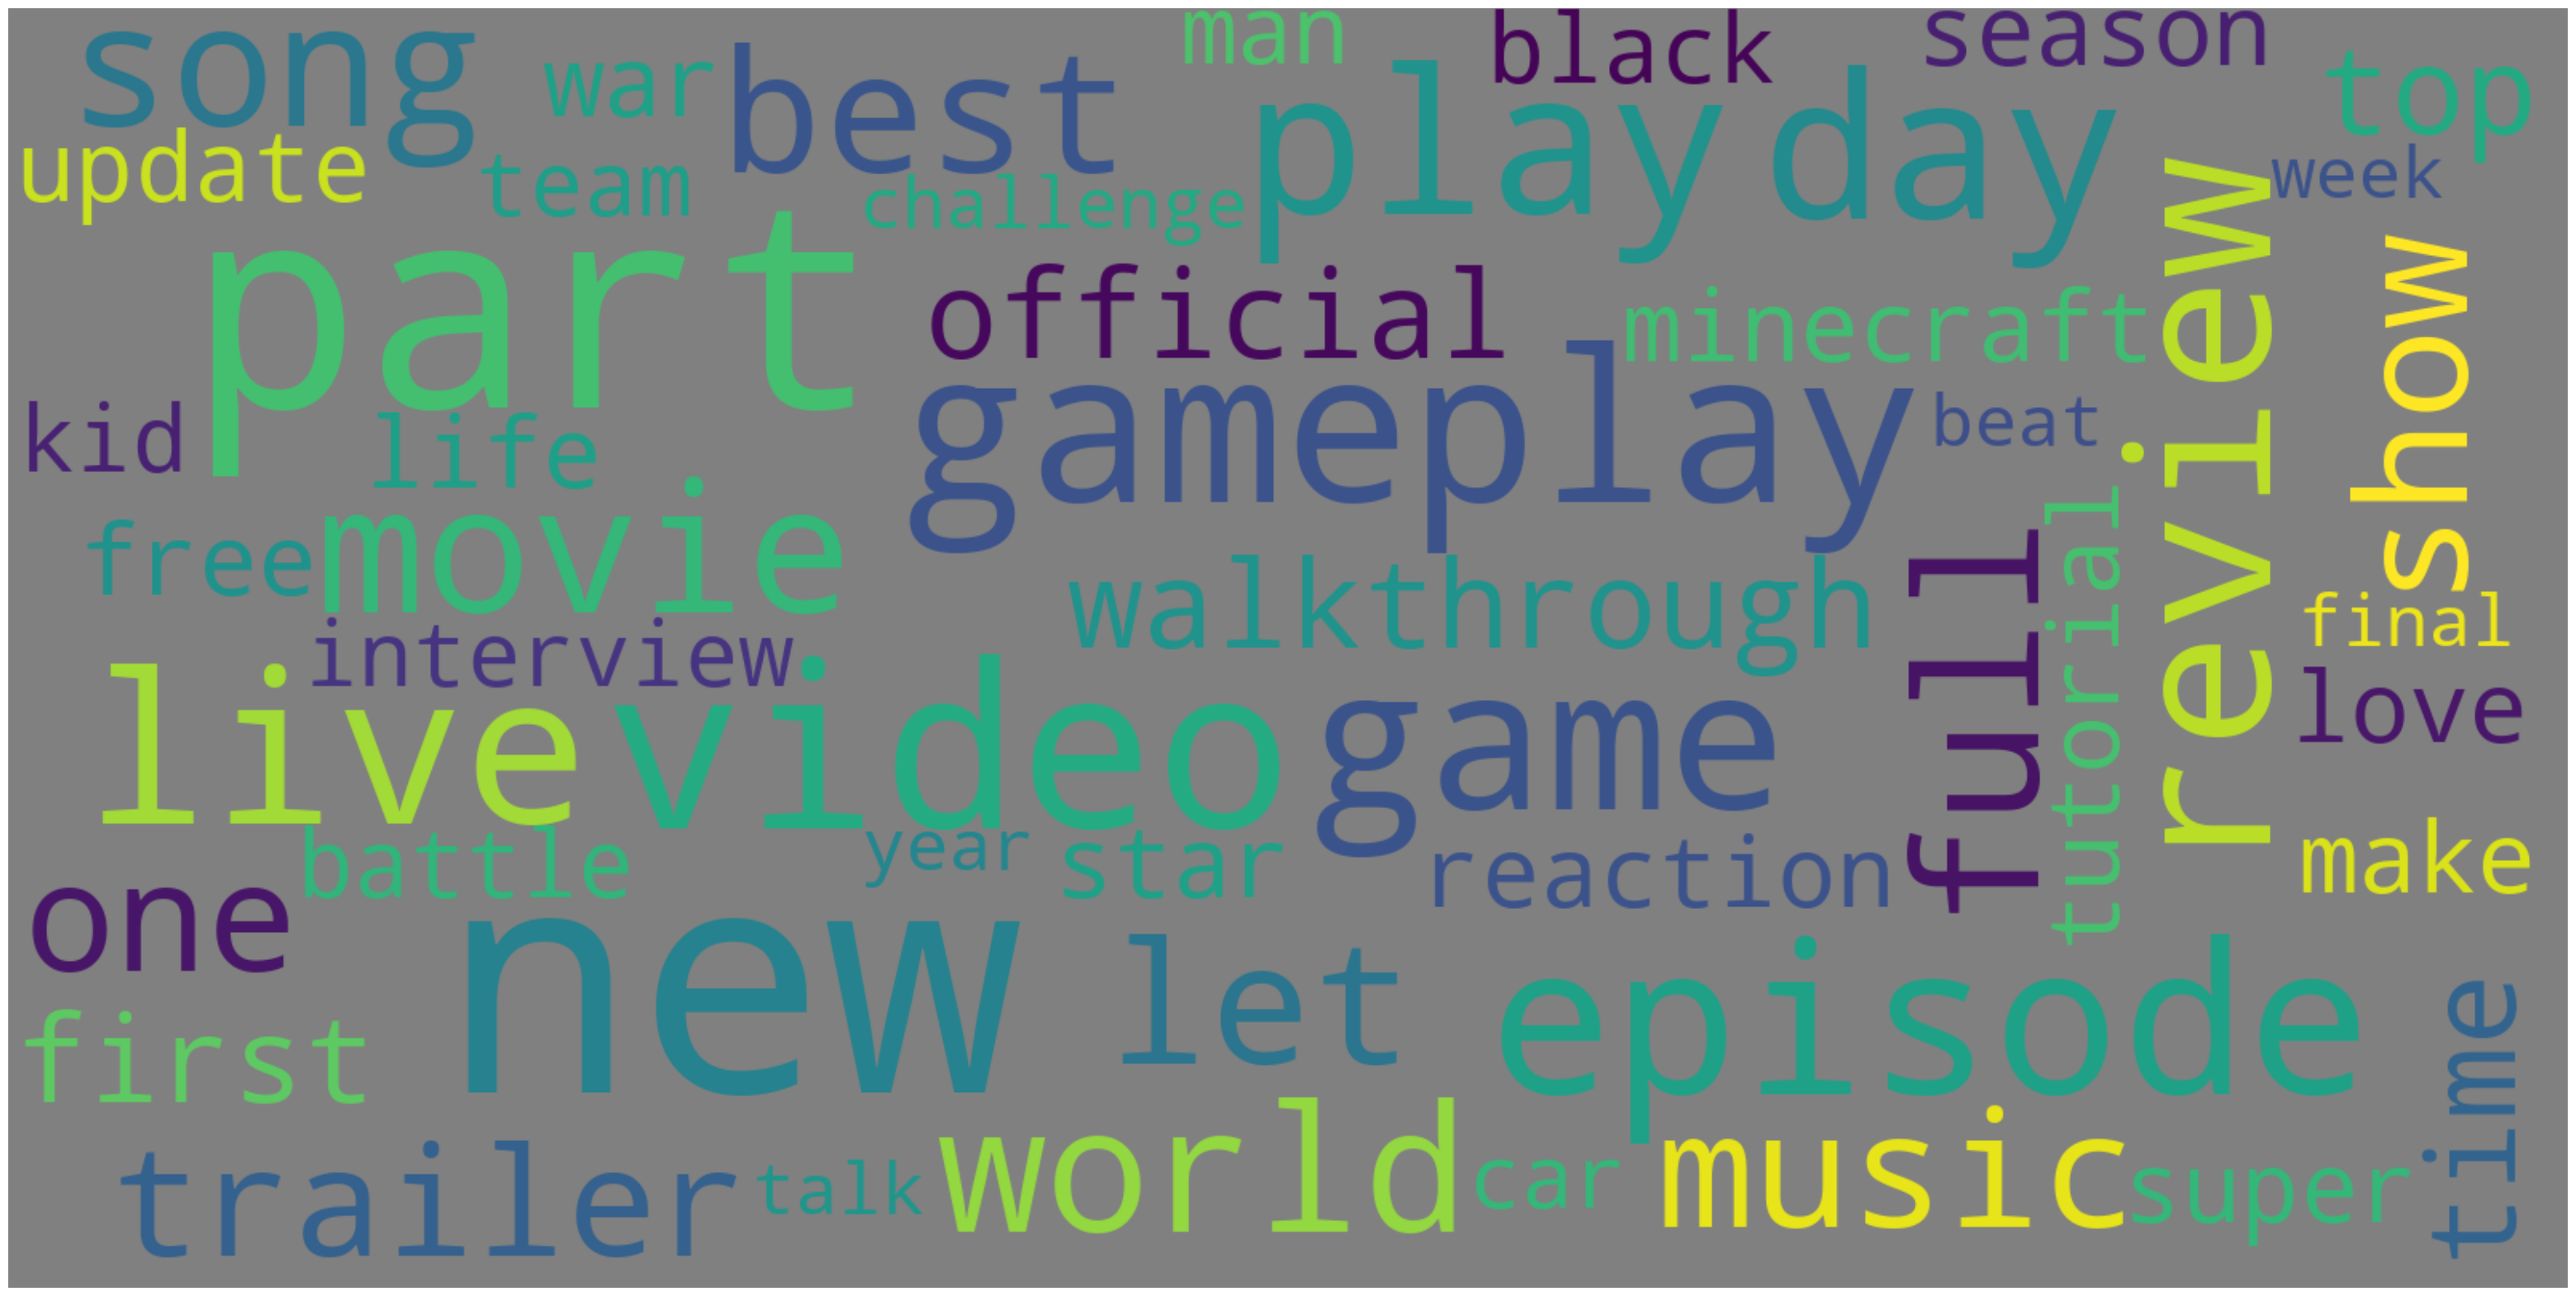

In [29]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=200,max_words=50,collocations=False, background_color='grey').generate(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [44]:
wordcloud.to_file('title_wordcloud.png')

In [27]:
from platform import python_version

In [28]:
python_version()

'3.9.12'